In [2]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os
import requests
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from decimal import Decimal

In [10]:
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression

In [84]:
def benefit_calc(model, X_train, y_train, X_test, y_test, X_OOT, y_OOT, r = 0.15, lgd = 1, n_qq= 2):
    max_val = {'thresh': 0, 'max_benefit_train': 0, 'max_benefit_train': 0}
    benefits = {}
    acceptance_rates = {}
    
    for it, i in tqdm(enumerate(['train', 'test', 'oot'])):
        if i == 'train':
            X = X_train.reset_index(drop = True)
            y = y_train.reset_index(drop = True)
            
        elif i == 'test':
            X = X_test.reset_index(drop = True)
            y = y_test.reset_index(drop = True)
        
        elif i == 'oot':
            X = X_OOT.reset_index(drop = True)
            y = y_OOT.reset_index(drop = True)

        benefit = []    
        c_acceptance_rate = []
        
        if isinstance(model, LogisticRegression):
            y_hat = model.predict_proba(X.drop(columns = 'funded_amnt'))[:, 1]
        else:
            y_hat = model.predict_proba(X)[:, 1]
        thr = np.linspace(0, 1, 50)
        
        for t in thr:
            cur_benefit = []
            for j in range(n_qq):
                idx = np.random.choice(X.index, int(len(X)*0.5))
                X_cur = X.loc[idx, 'funded_amnt']
                y_cur = y.loc[idx]
                y_hat_cur = y_hat[idx]
                CM = confusion_matrix(y_cur, (y_hat_cur > t)*1.)  
                
                #calculate accaptance rate as amount of non-defaulted clients
                TN = CM[0][0]
                FN = CM[1][0]
                benef = TN*X_cur.mean()*r - FN * X_cur.mean() * lgd
                cur_benefit.append(benef)
            c_acceptance_rate.append((len(y_hat) - np.sum((y_hat > t)*1.)) / len(y_hat))
            ben = np.array(cur_benefit)
            if i == 'train' and np.mean(ben) > max_val['max_benefit_train']:
                max_val['thresh'] = t
                max_val['max_benefit_train'] = np.mean(ben)
            if i == 'test' and t == max_val['thresh']:
                max_val['max_benefit_test'] = [np.quantile(ben, 0.01),  np.mean(ben),np.quantile(ben, 0.99)]
            benefit.append([np.quantile(ben, 0.01),  np.mean(ben),np.quantile(ben, 0.99)])
            
        benefits.update({i: benefit})
        acceptance_rates.update({i: c_acceptance_rate})
    return benefits, acceptance_rates, max_val

In [92]:
def plot(benefits, acceptance_rates, max_val_cb, model_nm = 'boosting', lgd = 1):
    left = max_val_cb['max_benefit_test'][0]
    mean = max_val_cb['max_benefit_test'][1]
    right = max_val_cb['max_benefit_test'][2]
    print(f'Ожидаемая максимальная прибыль {"%.2E" % Decimal(mean)}')
    print(f"Доверительный интервал для максимальной прибыли: ({'%.2E' % Decimal(left)}; {'%.2E' % Decimal(right)})")
    fig, ax = plt.subplots(figsize = (10,6))
    for key, bens in benefits.items():
        y = np.array(bens)[:,1]
        lower = np.array(bens)[:,0]
        upper = np.array(bens)[:,2]
        x = acceptance_rates[key]
        ax.plot(x,y)
        ax.fill_between(x, lower, upper, label = key)
    plt.title(f'Benefits for {model_nm}, LGD = {lgd}')
    plt.xlabel('acceptance rate')
    plt.ylabel('benefit')
    plt.legend()
    plt.grid()
    plt.show()

Catboost

In [7]:
import yaml
from catboost import CatBoostClassifier, Pool, cv
# основные пути и файлы
working_path = '/home/nikita/risk_managment'
data_path = os.path.join(working_path,'cat_boost_data')
model_path = os.path.join(working_path,'models')
model_name = 'catboost'

train_file = 'catboost_train.csv'
oos_file = 'catboost_oos.csv'
oot_file = 'catboost_oot.csv'
config_file = 'catboost_data_config.yml'
# конфиг датасета
with open(os.path.join(working_path,config_file),'r',encoding='utf-8') as config:
    data_config = yaml.full_load(config)

# данные
train = pd.read_csv(os.path.join(data_path,train_file)).fillna(dict(zip(data_config['roles']['category'],['None'] * len(data_config['roles']['category'])))) \
              .sort_values(data_config['time_col'])
y_train_cb = train[data_config['roles']['target']]
x_train_cb = train.drop(columns = data_config['roles']['drop'] + [data_config['roles']['target']])

oos = pd.read_csv(os.path.join(data_path,oos_file)).fillna(dict(zip(data_config['roles']['category'],['None'] * len(data_config['roles']['category']))))
y_oos_cb = oos[data_config['roles']['target']]
x_oos_cb = oos.drop(columns = data_config['roles']['drop'] + [data_config['roles']['target']])

oot = pd.read_csv(os.path.join(data_path,oot_file)).fillna(dict(zip(data_config['roles']['category'],['None'] * len(data_config['roles']['category']))))
y_oot_cb = oot[data_config['roles']['target']]
x_oot_cb = oot.drop(columns = data_config['roles']['drop'] + [data_config['roles']['target']])

In [8]:
cb = joblib.load('models/simple_catboost.pkl')

logreg

In [76]:
target = 'loan_condition_int'

train = pd.read_csv('data/train_for_7').drop(columns = 'Unnamed: 0')
x_train_lr = train.drop(columns = [target] + ['issue_d'])
y_train_lr = train[target]

test = pd.read_csv('data/test_for_7').drop(columns = 'Unnamed: 0')
x_test_lr = test.drop(columns = [target] + ['issue_d'])
y_test_lr = test[target]

oot = pd.read_csv('data/oot_for_7').drop(columns = 'Unnamed: 0')
x_oot_lr = oot.drop(columns = [target] + ['issue_d'])
y_oot_lr = oot[target]

In [73]:
lr = joblib.load('models/interpret.pkl')

In [86]:
benefits_cb, acceptance_rates_cb, max_val_cb = benefit_calc(cb, x_train_cb, y_train_cb, x_oos_cb, y_oos_cb\
                                                , x_oot_cb, y_oot_cb, n_qq = 5)

3it [01:54, 38.12s/it]


In [87]:
benefits_cb1, acceptance_rates_cb1, max_val_cb1 = benefit_calc(cb, x_train_cb, y_train_cb, x_oos_cb, y_oos_cb\
                                                , x_oot_cb, y_oot_cb, n_qq = 5, lgd = 0.8)

3it [01:59, 39.80s/it]


In [88]:
benefits_lr, acceptance_rates_lr, max_val_lr = benefit_calc(lr, x_train_lr, y_train_lr, x_test_lr, y_test_lr\
                                                , x_oot_lr, y_oot_lr, n_qq = 5)

3it [02:00, 40.19s/it]


In [89]:
benefits_lr1, acceptance_rates_lr1, max_val_lr1 = benefit_calc(lr, x_train_lr, y_train_lr, x_test_lr, y_test_lr\
                                                , x_oot_lr, y_oot_lr, n_qq = 5, lgd = 0.8)

3it [02:02, 40.76s/it]


Ожидаемая максимальная прибыль 3.16E+08
Доверительный интервал для максимальной прибыли: (3.15E+08; 3.17E+08)


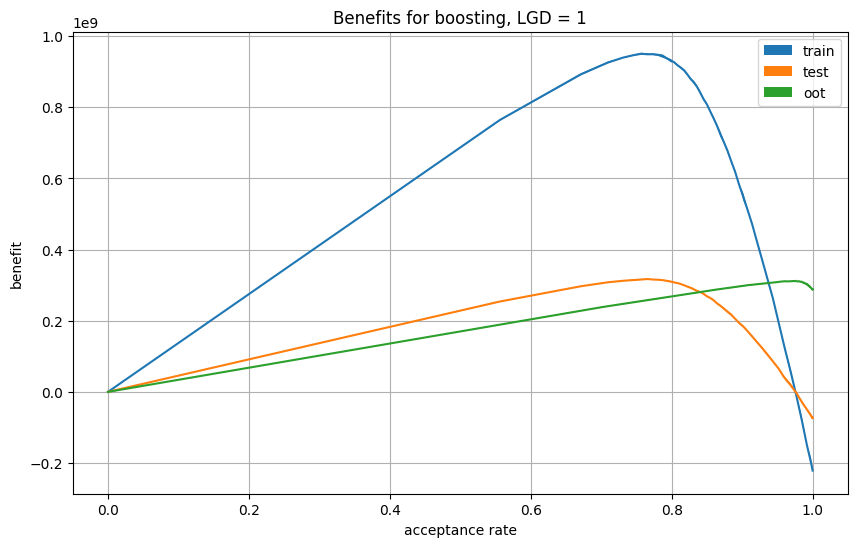

In [93]:
plot(benefits_cb, acceptance_rates_cb, max_val_cb)

Ожидаемая максимальная прибыль 3.09E+08
Доверительный интервал для максимальной прибыли: (3.08E+08; 3.10E+08)


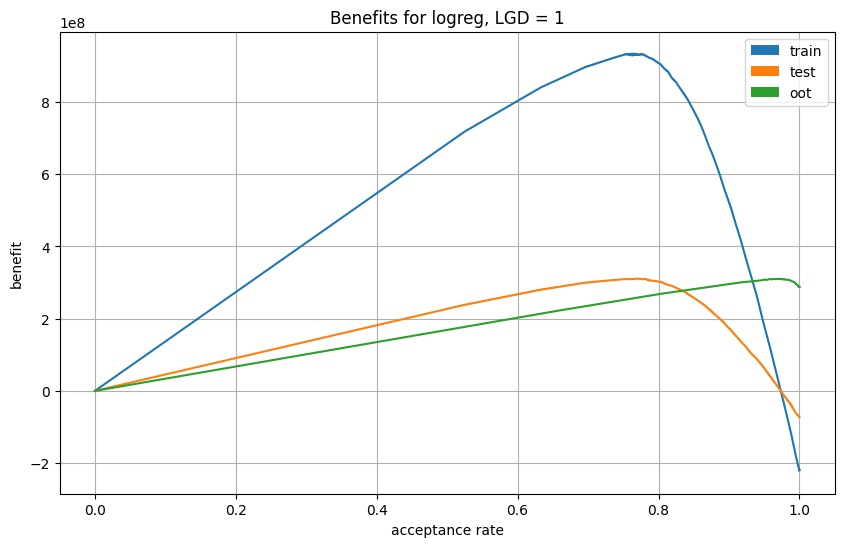

In [94]:
plot(benefits_lr, acceptance_rates_lr, max_val_lr, model_nm = 'logreg')

Ожидаемая максимальная прибыль 3.26E+08
Доверительный интервал для максимальной прибыли: (3.25E+08; 3.28E+08)


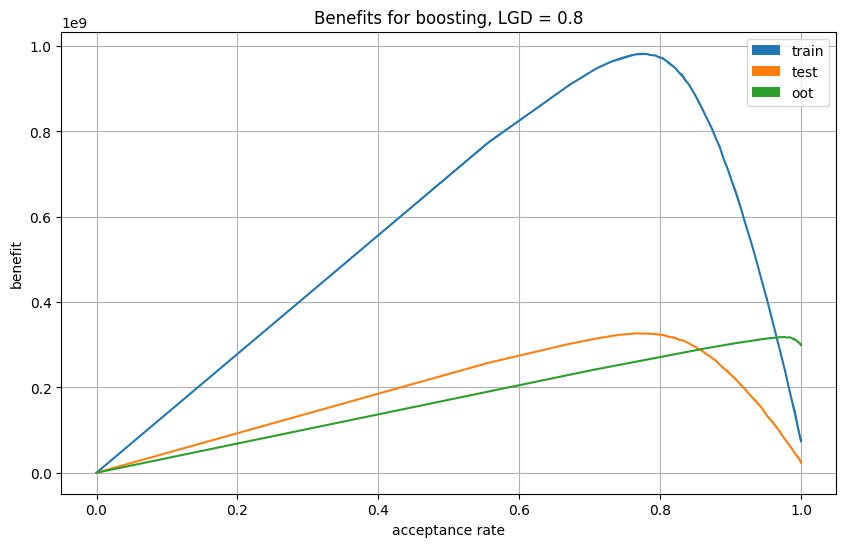

In [95]:
plot(benefits_cb1, acceptance_rates_cb1, max_val_cb1, lgd = 0.8)

Ожидаемая максимальная прибыль 3.22E+08
Доверительный интервал для максимальной прибыли: (3.21E+08; 3.22E+08)


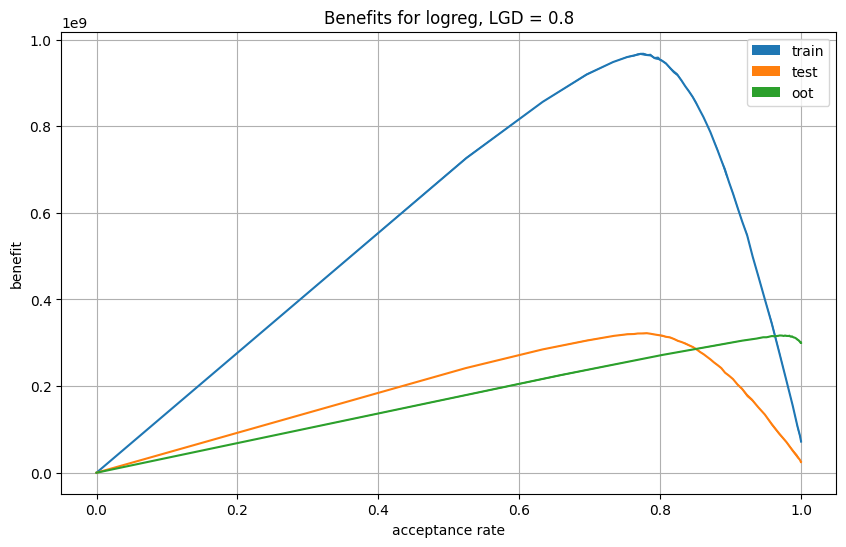

In [96]:
plot(benefits_lr1, acceptance_rates_lr1, max_val_lr1, model_nm = 'logreg', lgd = 0.8)

In [119]:
# def benefit_calc_2(model, X_train, y_train, X_test, y_test, X_OOT, y_OOT, e_fp, e_fn, n_qq= 2):
#     max_val = []
#     benefits = {}
#     acceptance_rates = {}
    
#     for it, i in enumerate(['train', 'test', 'oot']):
#         if i == 'train':
#             X = X_train.reset_index(drop = True)
#             y = y_train.reset_index(drop = True)
            
#         elif i == 'test':
#             X = X_test.reset_index(drop = True)
#             y = y_test.reset_index(drop = True)
        
#         elif i == 'oot':
#             X = X_OOT.reset_index(drop = True)
#             y = y_OOT.reset_index(drop = True)

#         benefit = []    
#         c_acceptance_rate = []
#         y_hat = model.predict_proba(X.drop(columns = 'funded_amnt'))[:, 1]
        
#         thr = np.linspace(0, 1, 50)
        
#         for t in thr:
#             cur_benefit = []
#             for j in range(n_qq):
#                 idx = np.random.choice(X.index, int(len(X)*0.5))
#                 y_cur = y.loc[idx]
#                 y_hat_cur = y_hat[idx]
#                 CM = confusion_matrix(y_cur, (y_hat_cur > t)*1.)  
                
#                 #calculate accaptance rate as amount of non-defaulted clients
#                 TN = CM[0][0]
#                 FN = CM[1][0]
#                 benef = TN * e_fp - FN * e_fn
#                 cur_benefit.append(benef)
#             #calculate the financial effect
#             c_acceptance_rate.append((len(y_hat) - np.sum((y_hat > t)*1.)) / len(y_hat))
#             ben = np.array(cur_benefit)
#             benefit.append([np.quantile(ben, 0.01),  np.mean(ben),np.quantile(ben, 0.99)])
            
#         benefits.update({i: benefit})
#         acceptance_rates.update({i: c_acceptance_rate})
#     return benefits, acceptance_rates